In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as xaxis
import os
import neo #Electrophys Tool
import pandas as pd
import scipy as scp
import time
from IPython.display import HTML  # to format drop downs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
import re
import random
import seaborn as sea

print(np.__version__)
print(scp.__version__)

1.26.4
1.12.0


In [2]:
%%html
<style>
  details summary {
    background-color: #ADD8E6;
    color: white;
    padding: 10px;
    border-radius: 5px;
    cursor: pointer;
    width: 155px;
  }
</style>

In [3]:
#Creating our validation block vs test block

Training_Mice_WT = [1, 35, 31, 28, 32, 33, 22, 3, 19, 13, 16, 25, 14, 9, 12, 4, 34, 20]
Validation_Mice_WT = [2, 5, 6, 7, 8, 10, 11, 15, 17, 18, 21, 23, 24, 26, 27, 29, 30]

''' 
#How the arrays were created
Training_Mice_WT = random.sample(range(1,36),18)
print(Training_Mice_WT)
Validation_Mice_WT = []
i  = 0
for Mouse in range(1,36):
    if int(Mouse) not in Training_Mice_WT:
        Validation_Mice_WT.append(Mouse)
        i = i+1
        
print(Validation_Mice_WT)
'''

' \n#How the arrays were created\nTraining_Mice_WT = random.sample(range(1,36),18)\nprint(Training_Mice_WT)\nValidation_Mice_WT = []\ni  = 0\nfor Mouse in range(1,36):\n    if int(Mouse) not in Training_Mice_WT:\n        Validation_Mice_WT.append(Mouse)\n        i = i+1\n        \nprint(Validation_Mice_WT)\n'

### Create a good structure for analyzing the data set

* Have one function which will do the whole comparison: Stim Level, Block Level, Session Level Reading,
* Really an array with the following settings: [Measures to compare, Measure's Level (Stim,Block,Sess)]
* Other Inputs: Do you want Raw or Cooked(PCA) outputs

* Output: PCA Data or Raw Data, and Variables

* And a separate function for the Spearman and plots

# Functions to Maintain

In [4]:
def plexon_import(filepath):

    reader = neo.PlexonIO(filepath)
    blks = reader.read()
    seg = blks[0].segments[0]
    seg.data_children
    
    #Get analog signal
    sig = seg.analogsignals[0]
    
    #Each sig index is one millisecond, but need to sort out the multiple channel issue
    sigLH = sig[:,0] #Left Hemisphere
    sigRH = sig[:,1] #Right Hemisphere
    #sigPz = sig[:,2] #Piezo Data
    
    #Extract data and time series to use
    datLH = sigLH.data
    datRH = sigRH.data
    #datPz = sigPz.data
    
    #Reshape data so it's just a 1-D array so it can plot
    shape = datLH.shape[0] #shape shouldn't change
    datLH = np.reshape(datLH,(shape)) 
    datRH = np.reshape(datRH,(shape)) 
    #datPz = np.reshape(datPz,(shape)) 
    
    #Event_times stores the time each strobe event occured
    #Event_labels stores the label (1,2 is familiar, 0 is grey screen, 3,4 is phase shifted)
    event_times = [e.times for e in seg.events]
    event_labels = [e.labels for e in seg.events]
    
    #Smooth
    Notcha,Notchb = scp.signal.iirnotch(60,100,fs=1000)
    datLH = scp.signal.filtfilt(Notcha,Notchb,datLH)
    datRH = scp.signal.filtfilt(Notcha,Notchb,datRH)
    #datPz = scp.signal.filtfilt(Notcha,Notchb,datPz)

    #Filter LFP 
    #sos = scp.signal.butter(1, 1, 'hp', fs=1000, output='sos')
    #datLH = scp.signal.sosfilt(sos, datLH)

    
    #Normalize the data to a baseline based on the mean
    base_end = int(min(event_times[3])*1000) #Convert to a millisecond unit of time
    base_start = 0 
    datLH = datLH - np.mean(datLH[base_start:base_end])
    datRH = datRH - np.mean(datRH[base_start:base_end])
    
    #Convcert the PCA values into Z-scores to see if that will improve performance
    datLH_mean = np.mean(datLH)
    datRH_mean = np.mean(datRH)
    datLH_std = np.std(datLH)
    datRH_std = np.std(datRH)

    datLH = (datLH - datLH_mean)/datLH_std
    datRH = (datRH - datRH_mean)/datRH_std
    '''
    #Change the piezo data into absolute values
    datPz = np.sqrt(datPz ** 2)
    
    
    #Pz Normalization
    scaler = StandardScaler()
    #scaler = RobustScaler()
    #scaler = MaxAbsScaler()
    #scaler = PowerTransformer()
    datPz = datPz.reshape(-1,1)
    datPz = scaler.fit_transform(datPz)
    datPz = datPz.T
    datPz = datPz[0]
    '''
    
    event_label = event_labels[3]
    event_time = event_times[3]

    
    return datLH,datRH,event_label,event_time

In [5]:
# Function for pulling the data in different forms (i.e. day/blocks/stim)
def importate(Folder,Mouse_Type=0,Mouse_Nums="",Start_Day=1,End_Day=7,Measure=0,Data_Level='Stim'):
              
    start = time.perf_counter()
    print('STARTED ==>', start)
    
    os.listdir(Folder)
    Data_Array = LevelCheck(Data_Level)

    if Folder == "CBSC":
        PrePost = 0 # Always Pre CNO
        for day in range(Start_Day,End_Day+1,1):
            files = os.listdir("CBSC/day " + str(day) + "/")
            for file in files:
                fname = "CBSC/day " + str(day) + "/" + file #Concatenate directory with file path to be able to run the function over all days
                if os.path.splitext(fname)[1] == '.plx':
                            
                    ##MEASURE  0 = Left Hemi, 1 = Right Hemi, 2 = Behavior       
                    Day = day  
                    Mouse = int(re.findall(r'\d+', file[0:9])[0])
                    if Mouse_Nums != "" and Mouse not in Training_Mice_WT:
                        continue
                    print(f'Day: {Day}, Mouse: {Mouse}')
        
                    LH_single,RH_single,Event_Labels,Event_Times = plexon_import(fname) 
                    
                    if 0 in Measure:
                        Data_Array = RouteEm(LH_single,Data_Array,Day,Mouse,0,Event_Labels,Event_Times,PrePost)
                    if 1 in Measure:
                        Data_Array = RouteEm(RH_single,Data_Array,Day,Mouse,1,Event_Labels,Event_Times,PrePost)
                    if 2 in Measure:
                        Data_Array = RouteEm(Pz_single,Data_Array,Day,Mouse,2,Event_Labels,Event_Times,PrePost)
        
                    Block = 0
                    
    elif Folder == "PV-hM4Di":
        for mouse in range(37,98,1): #Mouse Numbers range from 37 to 97
            if os.path.exists(Folder + "/D" + str(mouse) + "/") == False:
                continue
            files = os.listdir(Folder + "/D" + str(mouse) + "/")
            for file in files:
                fname = Folder + "/D" + str(mouse) + "/" + file #Concatenate directory with file path to be able to run the function over all days
                if os.path.splitext(fname)[1] == '.plx':
                    dayloc = file.find("day")
                    if dayloc == -1:
                        continue
                    Day = int(re.findall(r'\d+', file[dayloc+3:dayloc+5])[0]) 
                    postloc = file.find("Post")
                    if file.find("Post") != -1 or file.find("post") != -1:
                        PrePost = 1 #0 for Pre, 1 for Post
                        Day = 8
                        if len(re.findall("Test", file[postloc:])) == 1:
                            continue
                    else:
                        PrePost = 0
                        
                    ##MEASURE  0 = Left Hemi, 1 = Right Hemi, 2 = Behavior       
                    
                    Mouse = mouse
                    if Mouse_Nums != "" and Mouse not in Training_Mice_WT:
                        continue
                    print(f'Day: {Day}, Mouse: {Mouse}')
        
                    LH_single,RH_single,Event_Labels,Event_Times = plexon_import(fname) 
                    
                    if 0 in Measure:
                        Data_Array = RouteEm(LH_single,Data_Array,Day,Mouse,0,Event_Labels,Event_Times,PrePost)
                    if 1 in Measure:
                        Data_Array = RouteEm(RH_single,Data_Array,Day,Mouse,1,Event_Labels,Event_Times,PrePost)
        
                    Block = 0
    finish = time.perf_counter()
    print('FINISHED ==>', round(finish - start))
    return Data_Array
    




In [6]:
# LevelCheck
def LevelCheck(Level):
    if Level=='Stim':
        Array = np.zeros([8,36,2,2,10,200,500])
    elif Level=='Block':
        Array = np.zeros([8,35,2,2,10,5000])
    elif Level=='Full':
        Array = np.zeros([8,35,2,2,500000])
    else:
        print('Your options are Stim, Block, or Full. Fix it :) ')
        Array = 1
    return Array

#RoutEm
def RouteEm(Data,Array,Day,Mouse,Measure,Event_Labels,Event_Times,PrePost):
    if Array.shape[4]==500000:
        Array = SessIT(Data,Array,Day,Mouse,Measure,Event_Labels,Event_Times,PrePost)
    elif Array.shape[5]==200:
        Array = StimIT(Data,Array,Day,Mouse,Measure,Event_Labels,Event_Times,PrePost)
    elif Array.shape[5]==5000:
        Array = BlockIT(Data,Array,Day,Mouse,Measure,Event_Labels,Event_Times,PrePost)

    return Array


# SessIT
def StimIT(Data,Array,Day,Mouse,Measure,Event_Labels,Event_Times,PrePost):
    Block = 0
    for event in range(0,len(Event_Labels),1):
        if Event_Labels[event] in ['1','2']: 
            Stim_Type = 0 # Familiar!
            
        elif Event_Labels[event] in ['3','4']: 
            Stim_Type = 1 # NOVEL!
        else:
            continue
        Event_Time = int(Event_Times[event]*1000)
        if Event_Time - int(Event_Times[event-1]*1000) >= 600:
            Block = Block+1
        #Left Hemi
        if len(Data[Event_Time:Event_Time+500]) < 500 or Block >= 10:
            print(Block)
            continue
        Array[Day-1,Mouse-37,Stim_Type,Measure,Block,event%200] = Data[Event_Time:Event_Time+500]
    return Array
         
# BlockIT
def BlockIT(Data,Array,Day,Mouse,Measure,Event_Labels,Event_Times,PrePost):
    
    Block = 0             
    for event in range(0,len(Event_Labels),1):
        
        if Event_Labels[event] in ['1','2']: 
            Stim_Type = 0 # Familiar!
        elif Event_Labels[event] in ['3','4']: 
            Stim_Type = 1 # NOVEL!
        else:
            continue
            
        Event_Time = int(Event_Times[event]*1000)
        
        if (Event_Time - int(Event_Times[event-1]*1000) >= 600) or Block == 0:
            
            if len(Data[Event_Time-100:Event_Time+99900]) < 100000: # or (Block > 4 and Day < 7):
                continue

            #Vidget if Piezo 
            if 2 in Measure:
                Array[Day-1,Mouse-37,Stim_Type,Measure,Block] = Data[Event_Time:Event_Time+5000]/np.mean(Data[Event_Time-2000:Event_Time])
            #else: 
             #   Array[Day-1,Mouse-1,Stim_Type,Measure,Block] = Data[Event_Time-100:Event_Time+99900]
            
            Block = Block+1
            
    return Array

# SessIT
def SessIT(Data,Array,Day,Mouse,Measure,Event_Labels,Event_Times,PrePost):
    Block = 0
    event = 0
    
    if Event_Labels[event] in ['1','2']: 
        Stim_Type = 0 # Familiar!
    elif Event_Labels[event] in ['3','4']: 
        Stim_Type = 1 # Novel
        
    Event_Time = int(Event_Times[event]*1000)

    Array[Day-1,Mouse-1,Stim_Type,2] = Data[Event_Time-100:Event_Time+5*200*500-100]
        
    return Array

In [7]:
#Masking
def Masker(Array):
    Array_T = Array
    Array_Masked = np.mean(Array_T,axis = len(Array_T.shape)-1)
    Array_Ind = Array_Masked != 0 #Everywhere that is not a null value    
    Array_Mask = Array_T[Array_Ind,:]
    return Array_Mask,Array_Ind


In [8]:
#Assign the values corresponding to each Block

def Variator(Array_T,Array_Ind):
    if len(Array_T.shape)==7:
        Stims = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[5]):
            Stims[:,:,:,:,:,i] = i
        Stims = Stims[Array_Ind].astype(int)
        
        Block = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[4]):
            Block[:,:,:,:,i,:] = i
        Block = Block[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Measure = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[3]):
            Measure[:,:,:,i,:,:] = i
        Measure = Measure[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Stim_Type
        Stim_Type = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[2]):
            Stim_Type[:,:,i,:,:,:] = i
        Stim_Type = Stim_Type[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Mouse = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[1]):
            Mouse[:,i,:,:,:,:] = i
        Mouse = Mouse[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Day = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[0]):
            Day[i,:,:,:,:,:] = i
        Day = Day[Array_Ind].astype(int)
        
        return Day,Mouse,Stim_Type,Measure,Block,Stims

    elif len(Array_T.shape)==6:
        Block = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[4]):
            Block[:,:,:,:,i] = i
        Block = Block[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Measure = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[3]):
            Measure[:,:,:,i,:] = i
        Measure = Measure[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Stim_Type
        Stim_Type = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[2]):
            Stim_Type[:,:,i,:,:] = i
        Stim_Type = Stim_Type[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Mouse = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[1]):
            Mouse[:,i,:,:,:] = i
        Mouse = Mouse[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Day = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[0]):
            Day[i,:,:,:,:] = i
        Day = Day[Array_Ind].astype(int)

        return Day,Mouse,Stim_Type,Measure,Block

    elif len(Array_T.shape)==5:
        
        #Assign the values corresponding to each Measure
        Measure = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[3]):
            Measure[:,:,:,i] = i
        Measure = Measure[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Stim_Type
        Stim_Type = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[2]):
            Stim_Type[:,:,i,:] = i
        Stim_Type = Stim_Type[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Mouse = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[1]):
            Mouse[:,i,:,:] = i
        Mouse = Mouse[Array_Ind].astype(int)
        
        #Assign the values corresponding to each Measure
        Day = np.zeros(Array_Ind.shape)
        for i in range(Array_T.shape[0]):
            Day[i,:,:,:] = i
        Day = Day[Array_Ind].astype(int)

        return Day,Mouse,Stim_Type,Measure

    


In [9]:
#Function to create the data frame of variables, regardless of whether at block, stim, day level
def Var_Data_Framer(Var_Tup):
    Names = [['Day'],['Mouse'],['Stim_Type'],['Measure'],['Block'],['Stim']]
    Var_DF = pd.DataFrame()
    for i in range(len(Var_Tup)):
        Level = pd.DataFrame(Var_Tup[i],columns = Names[i])
        Var_DF = pd.concat((Var_DF,Level),axis=1)
    return Var_DF

# PV PCA Fit Process

## Pull WT Mice Data, and run PCA
* Run PCA on WT, Left and Right, Novel Stim Included

In [10]:
Folder = "CBSC"
Mouse_Type = 0 # 0 for WT, 1 for PV
Mice_Numbers = Training_Mice_WT # Set to an array of the mouse numbers desired, for ex see Training_Mice_WT, or leave ""
Start_Day = 1 #
End_Day = 2 # anything greater than 9 will error
Measure = [0,1] #One value or an array of values. 0 for Left Hemisphere, 1 for Right, 2 for Piezo
Data_Level = 'Stim' # 'Stim', 'Block', or 'Full' session level. NOTE: For Piezo, it's either 'Full' or 'Vidget'

Dat_WT = importate(Folder,Mouse_Type,Mice_Numbers,Start_Day,End_Day,Measure,Data_Level)


STARTED ==> 221437.960197625
Day: 1, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 559240.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 322.17it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 103517.42it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


TypeError: RouteEm() missing 1 required positional argument: 'PrePost'

In [51]:
np.save('Data_WT_LFP_Stim_1to7',Dat_WT)

In [13]:
Dat_WT = np.load('WTMice Data/Data_WT_LFP_Stim_1to7.npy')

In [14]:
WT_Mask,WT_Ind = Masker(Dat_WT)

In [15]:
WT_Vars = Variator(Dat_WT,WT_Ind) #Get variable for each data point in a flat array

In [20]:
pca_WT = PCA(n_components=70)    
  
scaler = StandardScaler()

WT_Mask = scaler.fit_transform(WT_Mask.T)

X_WT=WT_Mask.T 


In [21]:
pca_WT.fit(X_WT);                  # Fit
DF_reduced_WT = pca_WT.transform(X_WT) # calculate the component scores for the components

In [94]:
np.save('PCA_WT_LFP_Stim_1to7',pca_WT)

In [95]:
np.save('DF_red_WT_LFP_Stim_1to7',DF_reduced_WT)

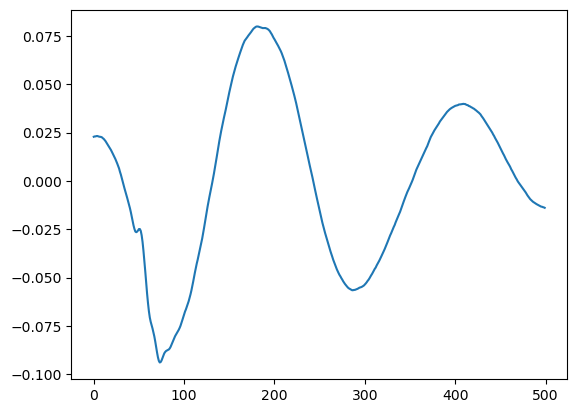

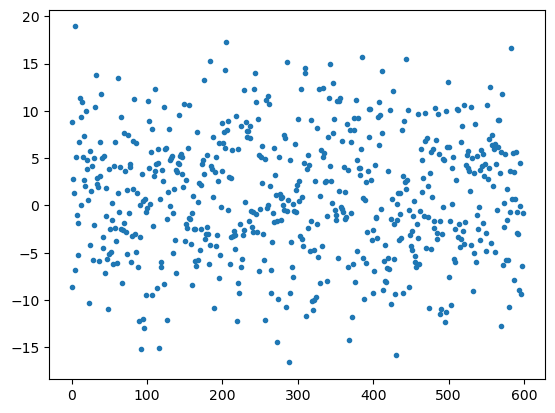

In [22]:
component = 1
plt.plot(pca_WT.components_[component,:])

plt.show()

plt.plot(DF_reduced_WT[1:600,0],'.')

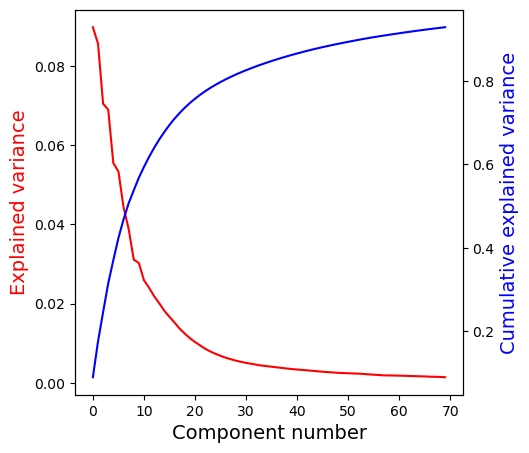

In [93]:
# Explained variance plot, in red
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pca_WT.explained_variance_ratio_,'r')
ax.set_xlabel("Component number", fontsize=14)
ax.set_ylabel("Explained variance", color="r", fontsize=14);

# Cumulative explained variance plot, in blue
ax3=ax.twinx()
ax3.plot(np.cumsum(pca_WT.explained_variance_ratio_),'b')
ax3.set_ylabel("Cumulative explained variance", color="blue", fontsize=14);

## Pull PV Mice Data, Fit to WT PCA

In [24]:
Folder = "PV-hM4Di"
Mouse_Type = 1 # 0 for WT, 1 for PV
Mice_Numbers = "" # Set to an array of the mouse numbers desired, for ex see Training_Mice_WT, or leave ""
Measure = [0,1] #One value or an array of values. 0 for Left Hemisphere, 1 for Right, 2 for Piezo
Data_Level = 'Stim' # 'Stim', 'Block', or 'Full' session level. NOTE: For Piezo, it's either 'Full' or 'Vidget'

Dat_PV = importate(Folder,Mouse_Type,Mice_Numbers,"","",Measure,Data_Level)

STARTED ==> 226430.612676958
Day: 5, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 745654.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 470.70it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 201441.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


3
3
Day: 7, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 935780.97it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 141.63it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 128350.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 104857.60it/s]


Day: 8, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 144.60it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 137518.16it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 2, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 932067.56it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 455.36it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 285396.14it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 133152.51it/s]


Day: 4, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 812737.11it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 480.08it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 304250.03it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 57260.12it/s]


3
3
Day: 6, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 863533.18it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 496.21it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 264208.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 50081.24it/s]


3
3
Day: 1, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 479.50it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 309461.16it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 147168.56it/s]


3
3
Day: 3, Mouse: 37


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 490.20it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 184800.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 60567.57it/s]


Day: 5, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 863533.18it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 482.21it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 251209.65it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 53430.62it/s]


Day: 7, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 145.49it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 173857.16it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 6, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 921102.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 489.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 272168.05it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 52593.15it/s]


Day: 4, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 801641.72it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 472.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 304250.03it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 72628.64it/s]


Day: 2, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 667275.64it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 458.34it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 183071.73it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 121574.03it/s]


Day: 8, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 745654.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 131.47it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 187904.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 121574.03it/s]


Day: 1, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 809934.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 412.84it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 261560.16it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 104857.60it/s]


Day: 3, Mouse: 38


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 481.29it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 200581.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 37786.52it/s]


3
3
Day: 6, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 496.59it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 256700.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


Day: 4, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 917504.00it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 496.71it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 300743.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


3
3
Day: 2, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 812737.11it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 479.44it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 302681.73it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 147168.56it/s]


Day: 5, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 468.60it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 302681.73it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 44979.13it/s]


Day: 3, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 812737.11it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 500.36it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 264208.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 128070.35it/s]


3
3
Day: 8, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 139.48it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 189267.55it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 7, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 913933.95it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 136.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 120637.40it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 1, Mouse: 39


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 876421.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 496.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 175677.65it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 35025.50it/s]


3
3
Day: 3, Mouse: 40


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 418.62it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 289976.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 153919.41it/s]


3
3
Day: 1, Mouse: 40


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 801641.72it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 446.12it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 270288.87it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 143395.01it/s]


3
3
Day: 7, Mouse: 40


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 133.31it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 152125.02it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 124275.67it/s]


Day: 8, Mouse: 40


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 906876.54it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 143.97it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 130852.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 124275.67it/s]


Day: 6, Mouse: 40


Finalizing data blocks for type 1: 100%|███| 56/56 [00:00<00:00, 1034718.17it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 502.76it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 284015.75it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 148470.94it/s]


Day: 2, Mouse: 40


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 824143.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 463.93it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 285743.34it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


Day: 4, Mouse: 40


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 409.24it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 271853.04it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 36711.63it/s]


3
3
Day: 5, Mouse: 40


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 777751.74it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 451.07it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 287492.07it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


Day: 5, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 402.97it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 278625.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 56299.38it/s]


Day: 7, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 876421.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 132.64it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 175546.36it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 120699.40it/s]


Day: 6, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 498.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 189115.16it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 159783.01it/s]


3
3
Day: 4, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 699050.67it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 406.49it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 299593.14it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


3
3
Day: 2, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 863533.18it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 489.53it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 254475.65it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 155344.59it/s]


Day: 1, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 821262.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 430.20it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 201961.33it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 53261.00it/s]


3
3
Day: 8, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 801641.72it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 139.90it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 133303.65it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 3, Mouse: 42


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 476.71it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 192367.75it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 147168.56it/s]


3
3
Day: 6, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 492.75it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 293234.74it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


3
3
Day: 4, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 724941.43it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 473.81it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 265102.74it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 148470.94it/s]


3
3
Day: 2, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 812737.11it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 439.13it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 290335.01it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


3
3
Day: 5, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 838860.80it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 502.18it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 153116.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 104857.60it/s]


3
3
Day: 3, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 485.97it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 194437.93it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 70197.56it/s]


Day: 1, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 851018.20it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 486.90it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 304250.03it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


Day: 8, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 982765.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 132.67it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 146984.37it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 7, Mouse: 43


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 913933.95it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 139.44it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 141750.77it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 3, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 947100.90it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 163.49it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 128490.71it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 2, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 180.13it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148470.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 7, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 82.12it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 124144.30it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 111107.39it/s]


Day: 1, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 178.12it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 132104.06it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 4, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 966588.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.75it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 145437.17it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 5, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 172.94it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 160437.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 8, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 81.11it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112437.06it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 143395.01it/s]


Day: 6, Mouse: 61


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 913933.95it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 168.98it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 131145.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 118149.41it/s]


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 173.76it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 216280.87it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 149796.57it/s]


Day: 7, Mouse: 62


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 79.84it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 152619.25it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 6, Mouse: 62


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 177.49it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 179435.47it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 2, Mouse: 62


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 179.49it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 147816.88it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 3, Mouse: 62


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 172.63it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 119228.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 134217.73it/s]


Day: 8, Mouse: 62


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 801641.72it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 82.55it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 141409.41it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 137518.16it/s]


Day: 1, Mouse: 62


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 935780.97it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 172.12it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 119108.02it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 143395.01it/s]


Day: 4, Mouse: 62


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 174.48it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 182929.15it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 2, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 177.71it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 122845.72it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 133152.51it/s]


Day: 3, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 168.84it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 169100.81it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 137518.16it/s]


Day: 1, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 159.13it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 141750.77it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 108942.96it/s]


Day: 4, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 176.16it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 142784.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 81840.08it/s]


Day: 8, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 80.31it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 122016.12it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 5, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 175.67it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 141069.68it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 133152.51it/s]


Day: 7, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 81.96it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 149796.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 6, Mouse: 63


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 171.05it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 150564.76it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 5, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 174.20it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 123882.40it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


Day: 1, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 179.26it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 150854.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 4, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 950935.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 173.79it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 93802.33it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 147168.56it/s]


Day: 3, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.86it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 145077.84it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 143395.01it/s]


Day: 6, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 175.63it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 169222.64it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 2, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 876421.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 174.77it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 153517.01it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 8, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 962627.15it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 77.88it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 138654.68it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 106184.91it/s]


Day: 7, Mouse: 64


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 80.56it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 125269.88it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 118987.35it/s]


Day: 7, Mouse: 65


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 788191.36it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 80.39it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 124737.67it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 5, Mouse: 65


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 809934.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 167.54it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 149796.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 111107.39it/s]


Day: 1, Mouse: 65


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 160.73it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 143658.12it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 121574.03it/s]


Day: 4, Mouse: 65


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 168.76it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 126962.72it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 3, Mouse: 65


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 886343.49it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 158.59it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 149796.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 138654.68it/s]


Day: 6, Mouse: 65


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 886343.49it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 173.81it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 125874.08it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 134217.73it/s]


Day: 8, Mouse: 65


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 745654.04it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 80.21it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 137598.73it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 913933.95it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 167.93it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 145437.17it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 108942.96it/s]


Day: 4, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 173.41it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 103153.72it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 1, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 932067.56it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 178.33it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 204244.37it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 142179.80it/s]


Day: 7, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 899927.30it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 80.82it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 123947.77it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 120699.40it/s]


Day: 5, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 917504.00it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 181.13it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 132401.93it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 2, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 876421.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 176.35it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 149036.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 3, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 947100.90it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 173.79it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113578.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 143395.01it/s]


Day: 6, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 876421.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 174.86it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 146252.19it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 8, Mouse: 66


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 917504.00it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 79.93it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 137598.73it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 56488.94it/s]


Day: 4, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 821262.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 172.41it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 151340.87it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 121574.03it/s]


Day: 1, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 185.97it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148096.48it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 140985.01it/s]


Day: 5, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 876421.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 167.24it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 131733.61it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 111848.11it/s]


Day: 7, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 928383.49it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 79.56it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 90027.22it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 2, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 821262.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 162.40it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 164252.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114912.44it/s]


Day: 3, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 174.93it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148658.88it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 6, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 172.09it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 170203.64it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 120699.40it/s]


Day: 8, Mouse: 67


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 80.52it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148564.85it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 121574.03it/s]


Day: 3, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 913933.95it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 175.28it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 128420.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 6, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 966588.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.80it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 209715.20it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 132104.06it/s]


Day: 2, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 171.29it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 189726.19it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 111107.39it/s]


Day: 7, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 899927.30it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 81.13it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 90338.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 5, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 913933.95it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.92it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115194.22it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 147168.56it/s]


Day: 1, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 164.78it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 143570.31it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 4, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 166.53it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 169100.81it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 8, Mouse: 68


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 81.23it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148096.48it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 118149.41it/s]


Day: 5, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 935780.97it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 179.74it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 120948.00it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 4, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 172.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 123621.59it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 104857.60it/s]


Day: 2, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 171.78it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 150564.76it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114912.44it/s]


Day: 7, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 921102.05it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 81.20it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 149320.42it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 153919.41it/s]


Day: 1, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.67it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148189.92it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 84733.41it/s]


Day: 8, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 903388.55it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 81.20it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 120205.23it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 6, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 812737.11it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 168.13it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 137921.92it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 3, Mouse: 70


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 812737.11it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 171.34it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 143307.52it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 4, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 921102.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 166.05it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148941.68it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 5, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 935780.97it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 180.08it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 128772.49it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 3, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 873163.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.73it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 174632.73it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 7, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 847945.94it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 79.77it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 142524.89it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 125203.10it/s]


Day: 2, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 950935.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 175.12it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 158596.23it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 148470.94it/s]


Day: 6, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 827045.86it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 177.30it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 155139.38it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 1, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 860370.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.70it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 188055.26it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 120699.40it/s]


Day: 8, Mouse: 71


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 748028.74it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 81.68it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113414.30it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 108240.10it/s]


Day: 1, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.21it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 127514.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 120699.40it/s]


Day: 8, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 775184.90it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 82.36it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 126962.72it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 129055.51it/s]


Day: 6, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 889700.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 168.95it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 145437.17it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 117323.19it/s]


Day: 2, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 913933.95it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 177.79it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 151731.93it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 121574.03it/s]


Day: 7, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 906876.54it/s]

Finalizing data blocks for type 4: 100%|██████████| 4/4 [00:00<00:00, 80.42it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 70789.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 121574.03it/s]


Day: 3, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 917504.00it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 175.05it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 137598.73it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 114130.72it/s]


Day: 5, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 832911.43it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 170.35it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 157216.21it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 142179.80it/s]


Day: 4, Mouse: 72


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 835875.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 175.19it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 141750.77it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 134217.73it/s]


FINISHED ==> 161


In [25]:
np.savez_compressed('PVMice Data/Data_PV_LFP_Stim_1to7',Dat_PV)

In [16]:
Dat_PV = np.load('PVMice Data/Data_PV_LFP_Stim_1to7.npz')

In [17]:
Dat_PV = Dat_PV['arr_0']

In [18]:
print(Dat_PV.shape)
Dat_PV[6][0][1][1].sum()

(8, 36, 2, 2, 10, 200, 500)


781.5490535437574

In [19]:
PV_Mask,PV_Ind = Masker(Dat_PV)

In [20]:
PV_Mask.shape

(553962, 500)

In [21]:
PV_Vars = Variator(Dat_PV,PV_Ind) #Get variable for each data point in a flat array

In [46]:
np.save('PV_Vars',PV_Vars)

In [48]:
PV_Vars2 = np.load('PV_Vars.npy')

In [22]:
pca_WT = PCA(n_components=70)    
  
scaler = StandardScaler()

#Scale the Wild Type Data
WT_Mask = scaler.fit_transform(WT_Mask.T)

X_WT=WT_Mask.T 


In [23]:
#Scale the PV Data the same way
PV_Mask = scaler.fit_transform(PV_Mask.T)

X_PV=PV_Mask.T 

In [24]:
pca_WT.fit(X_WT);                  # Fit with the WT Data


In [25]:
DF_reduced_PV = pca_WT.transform(X_PV) # calculate the PV component scores

In [ ]:
import pickle 

In [31]:
import joblib

In [33]:
joblib.dump(pca_WT,'PCA_WT.joblib')

['PCA_WT.joblib']

In [40]:
joblib.dump(DF_reduced_PV,'reduced_PV.joblib')

['reduced_PV.joblib']

In [41]:
PCA_WT2 = joblib.load('PCA_WT.joblib')
DF_reduced_PV2 = joblib.load('reduced_PV.joblib')
#help(joblib.load)

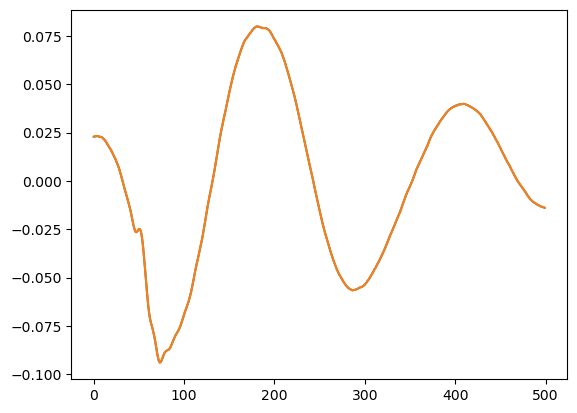

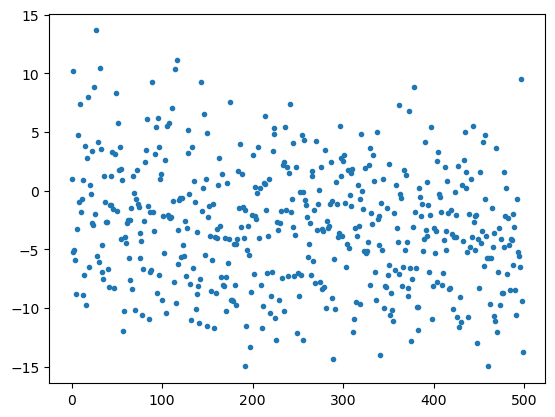

In [43]:
component = 1
plt.plot(PCA_WT2.components_[component,:])
plt.plot(pca_WT.components_[component,:])

plt.show()

plt.plot(DF_reduced_PV[1:500,component],'.')

## Do the various comparisons
* Day over Day
* Block over Block
* Novel Before Injection vs Novel After Injection
* Familiar Before Injection vs Familiar After Injection (Possibly combine with above)

### Day over Day

In [188]:
print(DF_reduced_PV.shape)
Day1 = PV_Vars[0] == 0
Day1_PV = DF_reduced_PV[Day1]
print(Day1_PV.shape)

Day_DF = np.zeros([8,70])
Fam = PV_Vars[2] == 0 # Familiar Only

for i in range(0,8,1):
    Days = PV_Vars[0] == i
    
    Comb_Ind =  Days.astype(int) + Fam.astype(int) 
    Comb_Ind = Comb_Ind == 2

    Days = DF_reduced_PV[Comb_Ind] 
    Day_DF[i] = np.mean(Days,axis = 0)

Day_DF.shape

(553962, 70)
(53592, 70)


(8, 70)

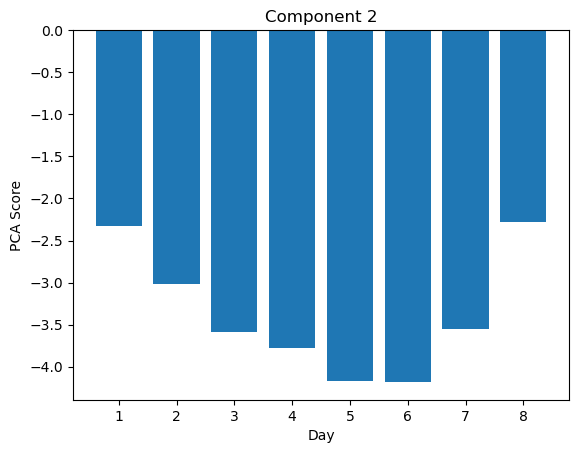

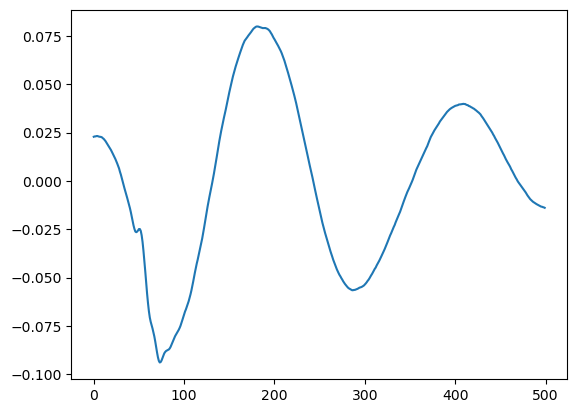

In [191]:
Component = 1
plt.bar(np.arange(1,9,1),Day_DF[:,Component]) 
plt.xlabel('Day')
plt.ylabel('PCA Score')
plt.title(f'Component {Component+1}')
# 7th component shows the 1-200 diff
plt.show()

plt.plot(pca_WT.components_[Component,:])

### Stim 1 v 2 v 200 in a block
* Focusing on Day 7, comparing novel and familiar and post CNO vs Pre CNO

In [166]:
print(DF_reduced_PV.shape)

Stim_DF = np.zeros([2,3,70])
Fam = PV_Vars[2] == 0
for k in range(0,2,1):
    
    Day = PV_Vars[0] == k + 6
    

    j = 0
    for i in [0,1,199]:
        Stim = PV_Vars[5] == i
        
        Comb_Ind =  Stim.astype(int) + Fam.astype(int) + Day.astype(int)
        Comb_Ind = Comb_Ind == 3
    
        Days = DF_reduced_PV[Comb_Ind] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1
Stim_DF.shape

(553962, 70)


(2, 3, 70)

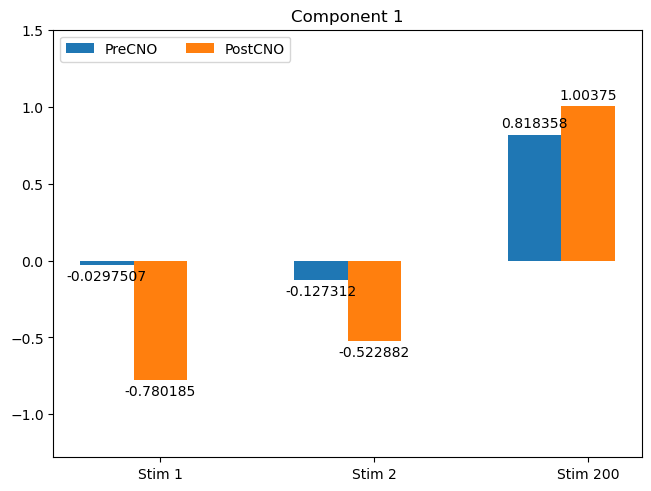

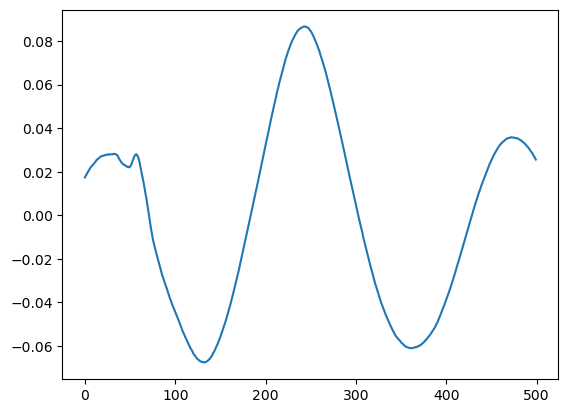

In [167]:
Component = 0
species = ("Stim 1", "Stim 2","Stim 200")
penguin_means = {
    'PreCNO': (Stim_DF[0,0,Component],Stim_DF[0,1,Component],Stim_DF[0,2,Component]),
    'PostCNO': (Stim_DF[1,0,Component],Stim_DF[1,1,Component],Stim_DF[1,2,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title(f'Component {Component+1}')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.5,max+.5)

plt.show()


plt.plot(pca_WT.components_[Component,:])

### Blocks
* Focusing on Day 7, comparing novel and familiar and post CNO vs Pre CNO

In [184]:
print(DF_reduced_PV.shape)

Stim_DF = np.zeros([2,3,70])
Fam = PV_Vars[2] == 0
for k in range(0,2,1):
    
    Day = PV_Vars[0] == k + 6
    j = 0
    for i in [0,4,9]:
        Block = PV_Vars[4] == i
        
        Comb_Ind =  Block.astype(int) + Fam.astype(int) + Day.astype(int)
        Comb_Ind = Comb_Ind == 3
    
        Days = DF_reduced_PV[Comb_Ind] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1

Stim_DF.shape

(553962, 70)


(2, 3, 70)

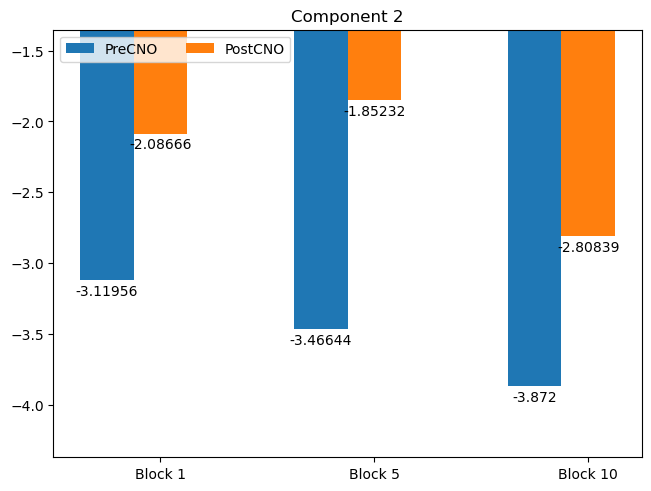

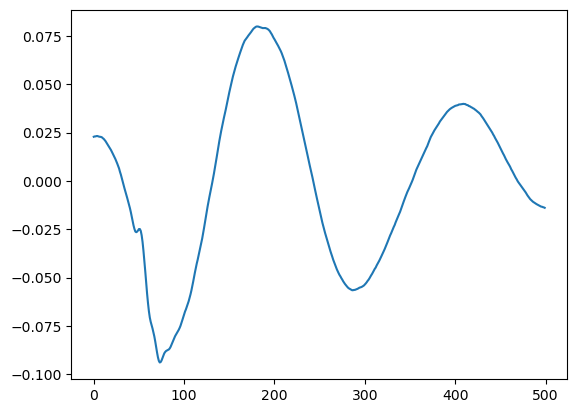

In [187]:
Component = 1
species = ("Block 1", "Block 5","Block 10")
penguin_means = {
    'PreCNO': (Stim_DF[0,0,Component],Stim_DF[0,1,Component],Stim_DF[0,2,Component]),
    'PostCNO': (Stim_DF[1,0,Component],Stim_DF[1,1,Component],Stim_DF[1,2,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title(f'Component {Component+1}')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.5,max+.5)

plt.show()


plt.plot(pca_WT.components_[Component,:])

# Doing Stats on the Data

## Anova

In [59]:
import statsmodels
from statsmodels.stats.anova import AnovaRM 

In [50]:
#Make the dataframe
Var_DF = Var_Data_Framer(PV_Vars)
Val_Frame = pd.DataFrame(DF_reduced_PV[:,0:5],columns = ['Comp 1','Comp 2','Comp 3','Comp 4','Comp 5'])
PV_DF = pd.concat((Var_DF,Val_Frame),axis=1)
PV_DF

,Day,Mouse,Stim_Type,Measure,Block,Stim,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5
0,0,0,0,0,0,0,-1.566650,11.884038,0.219815,-2.404634,1.833997
1,0,0,0,0,0,1,3.670155,1.046816,1.179819,2.187454,-1.133220
2,0,0,0,0,0,2,-0.767269,-5.203259,-5.402089,-1.766268,5.393509
3,0,0,0,0,0,3,9.784025,10.217502,1.106993,2.117516,-5.803698
4,0,0,0,0,0,4,4.923598,-5.071033,-9.979399,0.130078,-6.000444
...,...,...,...,...,...,...,...,...,...,...,...
553957,7,35,1,1,9,195,-5.234265,6.785905,1.893920,-2.506560,1.310479
553958,7,35,1,1,9,196,-3.505200,-4.722980,-0.976982,-7.215265,-2.869370
553959,7,35,1,1,9,197,9.376100,-6.159771,2.848537,5.366030,0.974882
553960,7,35,1,1,9,198,7.187393,-7.463564,3.773763,6.324756,3.402974


In [51]:
PV_DF.to_pickle('PV_DF')

In [53]:
PV_DF2 = pd.read_pickle('PV_DF')

,Day,Mouse,Stim_Type,Measure,Block,Stim,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5
0,0,0,0,0,0,0,-1.566650,11.884038,0.219815,-2.404634,1.833997
1,0,0,0,0,0,1,3.670155,1.046816,1.179819,2.187454,-1.133220
2,0,0,0,0,0,2,-0.767269,-5.203259,-5.402089,-1.766268,5.393509
3,0,0,0,0,0,3,9.784025,10.217502,1.106993,2.117516,-5.803698
4,0,0,0,0,0,4,4.923598,-5.071033,-9.979399,0.130078,-6.000444
...,...,...,...,...,...,...,...,...,...,...,...
553957,7,35,1,1,9,195,-5.234265,6.785905,1.893920,-2.506560,1.310479
553958,7,35,1,1,9,196,-3.505200,-4.722980,-0.976982,-7.215265,-2.869370
553959,7,35,1,1,9,197,9.376100,-6.159771,2.848537,5.366030,0.974882
553960,7,35,1,1,9,198,7.187393,-7.463564,3.773763,6.324756,3.402974


### Troubleshooting

In [45]:
PV_DF['Mouse'].value_counts()

Mouse
26    40000
27    40000
34    40000
33    40000
31    40000
30    40000
29    40000
35    40000
25    40000
24    39600
28    39200
1     19198
3     19194
2     19194
6     19192
5     19192
0     19192
Name: count, dtype: int64

In [65]:
Mouse_DF = PV_DF.loc[PV_DF['Mouse']==0]  
Mouse_DF

,Day,Mouse,Stim Type,Measure,Block,Stim,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5
0,0,0,0,0,0,0,-1.566650,11.884038,0.219815,-2.404634,1.833997
1,0,0,0,0,0,1,3.670155,1.046816,1.179819,2.187454,-1.133220
2,0,0,0,0,0,2,-0.767269,-5.203259,-5.402089,-1.766268,5.393509
3,0,0,0,0,0,3,9.784025,10.217502,1.106993,2.117516,-5.803698
4,0,0,0,0,0,4,4.923598,-5.071033,-9.979399,0.130078,-6.000444
...,...,...,...,...,...,...,...,...,...,...,...
442757,7,0,1,1,5,195,-2.491974,8.414161,5.995420,6.860990,-2.894854
442758,7,0,1,1,5,196,3.371134,-10.269642,-3.088386,7.937370,4.003205
442759,7,0,1,1,5,197,-9.071039,-2.890786,0.897820,3.472172,-6.094568
442760,7,0,1,1,5,198,1.959430,-12.307884,6.554906,-2.455677,-2.272814


In [70]:
Dat_PV[0,0,0,0,3].sum()

17.668202309716506

In [75]:
filepath = 'PV-hM4Di/D72/042313-D72-15deg-Vidgetday1.plx'
reader = neo.PlexonIO(filepath)
blks = reader.read()
seg = blks[0].segments[0]
seg.data_children

#Get analog signal
sig = seg.analogsignals[0]

#Each sig index is one millisecond, but need to sort out the multiple channel issue
sigLH = sig[:,0] #Left Hemisphere
sigRH = sig[:,1] #Right Hemisphere
#sigPz = sig[:,2] #Piezo Data

#Extract data and time series to use
datLH = sigLH.data
datRH = sigRH.data
#datPz = sigPz.data

Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 824143.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 169.68it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 127237.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 122461.43it/s]


In [79]:
sig

AnalogSignal with 3 channels of length 1778880; units dimensionless; datatype float32
name: 'Signals 0'
annotations: {'stream_id': '0'}
sampling rate: 1000.0 Hz
time: 0.0 s to 1778.88 s

In [74]:
sig37 

AnalogSignal with 2 channels of length 495360; units dimensionless; datatype float32
name: 'Signals 0'
annotations: {'stream_id': '0'}
sampling rate: 1000.0 Hz
time: 0.0 s to 495.36 s

In [78]:
sig.shape[0]/sig37.shape[0]

3.5910852713178296

## Continue with ANOVA

In [54]:
# Cutting out the mice who aren't full 

PV_Cut = PV_DF
Slice = PV_Cut['Mouse'].value_counts() == 40000
Slice = Slice.reset_index()
Slice = pd.DataFrame(Slice)
Slice['count'] 
GoodMice = Slice.loc[Slice['count']==True]
GoodMice
PV_Cut = pd.merge(PV_Cut, GoodMice, how='left', on='Mouse')
PV_Cut = PV_Cut.loc[PV_Cut['count']==True]
PV_Cut

,Day,Mouse,Stim_Type,Measure,Block,Stim,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,count
13592,0,25,0,0,0,0,-4.706214,3.650607,-5.021320,-0.637336,1.328270,True
13593,0,25,0,0,0,1,-1.063096,3.384504,-0.743055,2.492712,-0.990784,True
13594,0,25,0,0,0,2,3.849019,-4.592540,9.687566,4.701933,4.473364,True
13595,0,25,0,0,0,3,8.923888,-4.383289,8.431350,-1.047171,-6.502055,True
13596,0,25,0,0,0,4,4.731385,1.190161,9.157728,2.577934,5.410665,True
...,...,...,...,...,...,...,...,...,...,...,...,...
553957,7,35,1,1,9,195,-5.234265,6.785905,1.893920,-2.506560,1.310479,True
553958,7,35,1,1,9,196,-3.505200,-4.722980,-0.976982,-7.215265,-2.869370,True
553959,7,35,1,1,9,197,9.376100,-6.159771,2.848537,5.366030,0.974882,True
553960,7,35,1,1,9,198,7.187393,-7.463564,3.773763,6.324756,3.402974,True


In [55]:
PV_Cut['Mouse'].value_counts()

Mouse
25    40000
26    40000
27    40000
29    40000
30    40000
31    40000
33    40000
34    40000
35    40000
Name: count, dtype: int64

In [29]:
for i in range(1,6,1):
    Anovate = AnovaRM(data=PV_Cut, depvar=f'Comp {i}', 
                  subject='Mouse', within=['Block','Stim_Type'],aggregate_func = 'mean').fit()
    print(Anovate)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Block            2.8966 9.0000 72.0000 0.0056
Stim_Type        3.6847 1.0000  8.0000 0.0912
Block:Stim_Type  1.9715 9.0000 72.0000 0.0552

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Block            1.0546 9.0000 72.0000 0.4065
Stim_Type       10.9503 1.0000  8.0000 0.0107
Block:Stim_Type  5.7669 9.0000 72.0000 0.0000

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Block            1.6985 9.0000 72.0000 0.1051
Stim_Type        0.9763 1.0000  8.0000 0.3520
Block:Stim_Type  4.8435 9.0000 72.0000 0.0000

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Block            2.8798 9.0000 72.0000 0.0058
Stim_Type        0.0842 1.0000  8.0000 0.7791
Block:Stim_Type  1.

In [57]:
# Create a Pre or Post column (False being Pre, True being Post)
PV_PP = PV_Cut
PV_PP['PrePost'] = (PV_PP['Day'])==7 # Create a new column for PrePost
PV_PP = PV_PP.replace({'Day': {7:6}}) #Change Day 7 to be Day 6
PV_PP["Day"].value_counts()

Day
6    144000
0     36000
1     36000
2     36000
3     36000
4     36000
5     36000
Name: count, dtype: int64

In [75]:
# Create a DataFrame with all the content
Anova_DF = pd.DataFrame()
for i in range(1,6,1):
    Anovate = AnovaRM(data=PV_PP, depvar=f'Comp {i}', 
                  subject='Mouse', within=['Stim','Stim_Type','PrePost'],aggregate_func = 'mean').fit()
    print(Anovate)
    DF = Anovate.anova_table
    DF['Component'] = i
    Anova_DF = pd.concat((Anova_DF,DF))
    

                         Anova
                       F Value  Num DF    Den DF  Pr > F
--------------------------------------------------------
Stim                    1.1079 199.0000 1592.0000 0.1577
Stim_Type              32.9194   1.0000    8.0000 0.0004
PrePost                 3.8853   1.0000    8.0000 0.0842
Stim:Stim_Type          1.0672 199.0000 1592.0000 0.2597
Stim:PrePost            0.9512 199.0000 1592.0000 0.6700
Stim_Type:PrePost       5.6861   1.0000    8.0000 0.0442
Stim:Stim_Type:PrePost  1.0125 199.0000 1592.0000 0.4424

                         Anova
                       F Value  Num DF    Den DF  Pr > F
--------------------------------------------------------
Stim                    1.0377 199.0000 1592.0000 0.3530
Stim_Type               9.0660   1.0000    8.0000 0.0168
PrePost                 0.9405   1.0000    8.0000 0.3605
Stim:Stim_Type          0.8946 199.0000 1592.0000 0.8424
Stim:PrePost            0.8717 199.0000 1592.0000 0.8925
Stim_Type:PrePost       9

In [126]:
Anova_DF2 = Anova_DF.reset_index()


ValueError: cannot insert level_0, already exists

In [133]:
Anova_DF2 = Anova_DF
Anova_DF2 = Anova_DF2.rename(columns = {'index':'Measure'})
Anova_DF2 = Anova_DF2.drop(columns = 'level_0')

In [140]:
Anova_DF2 = Anova_DF2.drop_duplicates(subset=['Measure','Component'])
Anova_DF2 = Anova_DF2.reset_index(drop=True)
Anova_DF2

,Measure,F Value,Num DF,Den DF,Pr > F,Component
0,Block,2.283784,9.0,72.0,0.025786,0
1,Stim_Type,32.919352,1.0,8.0,0.000435,0
2,PrePost,3.885338,1.0,8.0,0.084197,0
3,Block:Stim_Type,2.876889,9.0,72.0,0.005862,0
4,Block:PrePost,1.562436,9.0,72.0,0.143181,0
5,Stim_Type:PrePost,5.686073,1.0,8.0,0.044231,0
6,Block:Stim_Type:PrePost,1.251355,9.0,72.0,0.278464,0
7,Block,1.069763,9.0,72.0,0.395445,1
8,Stim_Type,9.066046,1.0,8.0,0.016788,1
9,PrePost,0.940524,1.0,8.0,0.360546,1


In [146]:
Anova_Sig = Anova_DF2.loc[Anova_DF2['Pr > F']<=0.05]
Anova_Sig = Anova_Sig.reset_index(drop=True)
Anova_Sig['Component'] = Anova_Sig['Component']+1
Anova_Sig

,Measure,F Value,Num DF,Den DF,Pr > F,Component
0,Block,2.283784,9.0,72.0,0.025786,1
1,Stim_Type,32.919352,1.0,8.0,0.000435,1
2,Block:Stim_Type,2.876889,9.0,72.0,0.005862,1
3,Stim_Type:PrePost,5.686073,1.0,8.0,0.044231,1
4,Stim_Type,9.066046,1.0,8.0,0.016788,2
5,Block:Stim_Type,3.727998,9.0,72.0,0.000694,2
6,Stim_Type:PrePost,9.873120,1.0,8.0,0.013760,2
7,Block:Stim_Type:PrePost,2.384385,9.0,72.0,0.020102,2
8,Stim_Type,9.830768,1.0,8.0,0.013901,3
9,Block:PrePost,3.311732,9.0,72.0,0.001965,3


,Measure,F Value,Num DF,Den DF,Pr > F,Component
0,Block,2.283784,9.0,72.0,0.025786,1
1,Stim_Type,32.919352,1.0,8.0,0.000435,1
2,Block:Stim_Type,2.876889,9.0,72.0,0.005862,1
3,Stim_Type:PrePost,5.686073,1.0,8.0,0.044231,1


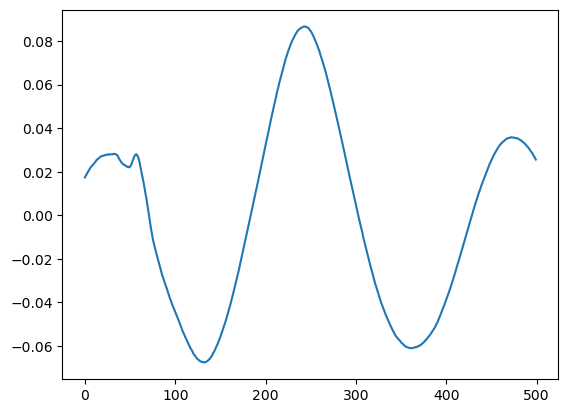

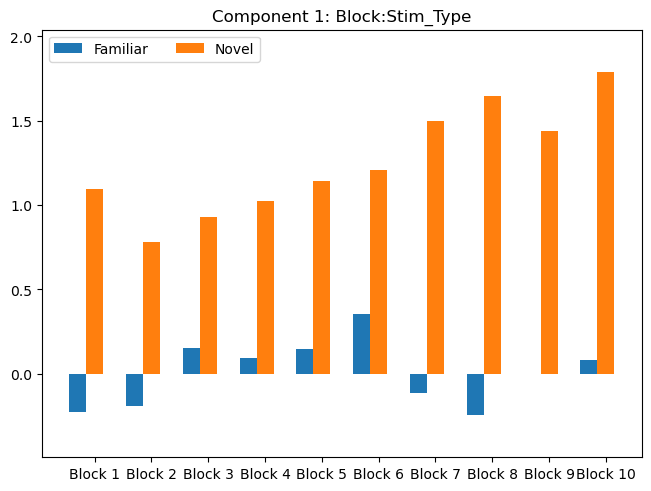

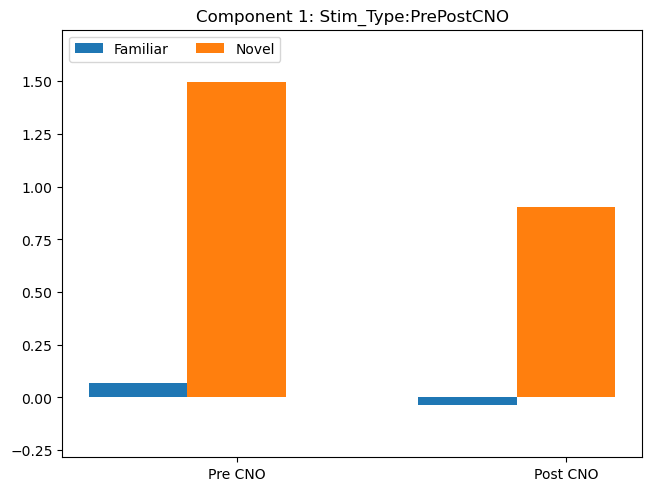

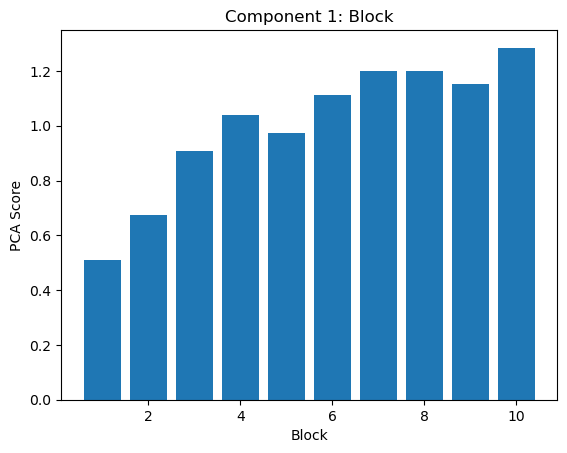

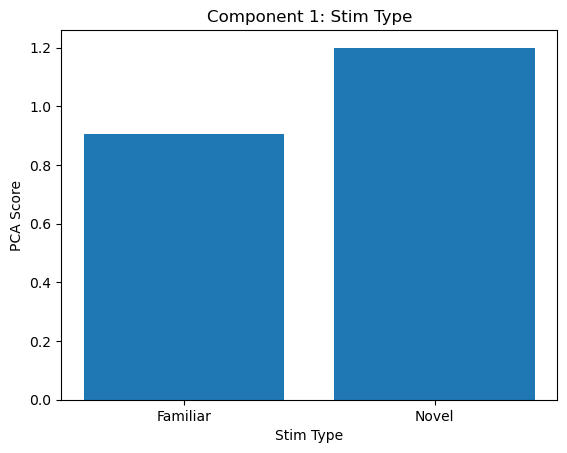

In [199]:
# Relevant Plots for Component 1
display(Anova_Sig.loc[Anova_Sig['Component']==1])
plt.plot(pca_WT.components_[Component,:])
plt.show()

# Comparing Block and Stim Type:
Stim_DF = np.zeros([2,10,5])
Day1 = PV_Vars[0] == 6 
Day2 = PV_Vars[0] == 7
for k in range(0,2,1):
    
    Fam = PV_Vars[2] == k
    j = 0
    for i in range(0,10,1):
        Block = PV_Vars[4] == i
        
        Comb_Ind =  Block.astype(int) + Fam.astype(int) + Day1.astype(int) + Day2.astype(int)
        Comb_Ind = Comb_Ind == 3
    
        Days = DF_reduced_PV[Comb_Ind,0:5] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1


Component = 0
species = ("Block 1", "Block 2","Block 3","Block 4","Block 5","Block 6","Block 7","Block 8","Block 9","Block 10")
penguin_means = {
    'Familiar': (Stim_DF[0,0,Component],Stim_DF[0,1,Component],Stim_DF[0,2,Component],Stim_DF[0,3,Component],Stim_DF[0,4,Component],\
              Stim_DF[0,5,Component],Stim_DF[0,6,Component],Stim_DF[0,7,Component],Stim_DF[0,8,Component],Stim_DF[0,9,Component]),
    'Novel': (Stim_DF[1,0,Component],Stim_DF[1,1,Component],Stim_DF[1,2,Component],Stim_DF[1,3,Component],Stim_DF[1,4,Component],\
              Stim_DF[1,5,Component],Stim_DF[1,6,Component],Stim_DF[1,7,Component],Stim_DF[1,8,Component],Stim_DF[1,9,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title(f'Component {Component+1}: Block:Stim_Type')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.25,max+.25)

plt.show()

# Comparing Stim Type and PV Inhibition:

Stim_DF = np.zeros([2,2,5])

for k in range(0,2,1):
    
    Fam = PV_Vars[2] == k
    j = 0
    for i in range(0,2,1):
        Block = PV_Vars[0] == i+6
        
        Comb_Ind =  Block.astype(int) + Fam.astype(int)
        Comb_Ind = Comb_Ind == 2
    
        Days = DF_reduced_PV[Comb_Ind,0:5] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1


species = ("Pre CNO","Post CNO")
penguin_means = {
    'Familiar': (Stim_DF[0,0,Component],Stim_DF[0,1,Component]),
    'Novel': (Stim_DF[1,0,Component],Stim_DF[1,1,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title(f'Component {Component+1}: Stim_Type:PrePostCNO')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.25,max+.25)

plt.show()

# Looking at Block for Component 1

Block_DF = np.zeros([10,70])

for i in range(0,10,1):
    Block = PV_Vars[4] == i

    Days = DF_reduced_PV[Block] 
    Block_DF[i] = np.mean(Days,axis = 0)

plt.bar(np.arange(1,11,1),Block_DF[:,Component]) 
plt.xlabel('Block')
plt.ylabel('PCA Score')
plt.title(f'Component {Component+1}: Block')

plt.show()

# Looking at Stim Type for Component 1

Block_DF = np.zeros([2,70])

for i in range(0,2,1):
    Block = PV_Vars[2] == i

    Days = DF_reduced_PV[Block] 
    Block_DF[i] = np.mean(Days,axis = 0)

plt.bar(['Familiar','Novel'],Block_DF[:,Component]) 
plt.xlabel('Stim Type')
plt.ylabel('PCA Score')
plt.title(f'Component {Component+1}: Stim Type')

plt.show()

,Measure,F Value,Num DF,Den DF,Pr > F,Component
4,Stim_Type,9.066046,1.0,8.0,0.016788,2
5,Block:Stim_Type,3.727998,9.0,72.0,0.000694,2
6,Stim_Type:PrePost,9.873120,1.0,8.0,0.013760,2
7,Block:Stim_Type:PrePost,2.384385,9.0,72.0,0.020102,2


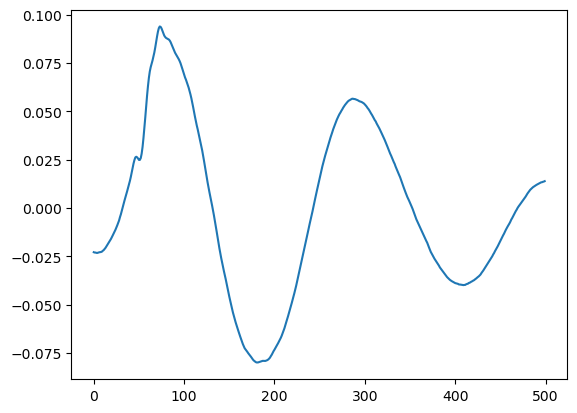

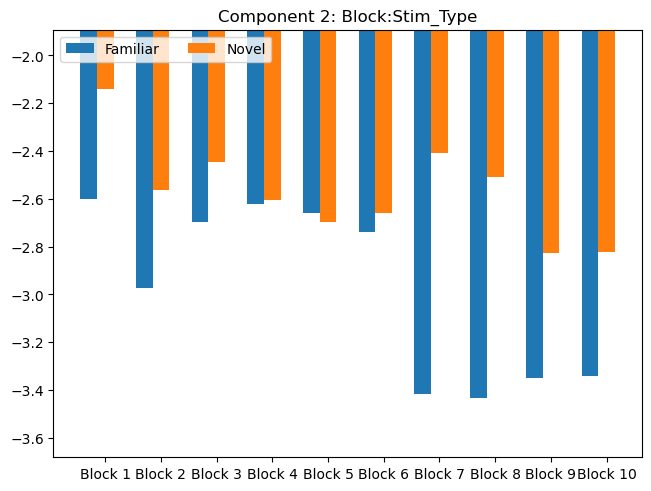

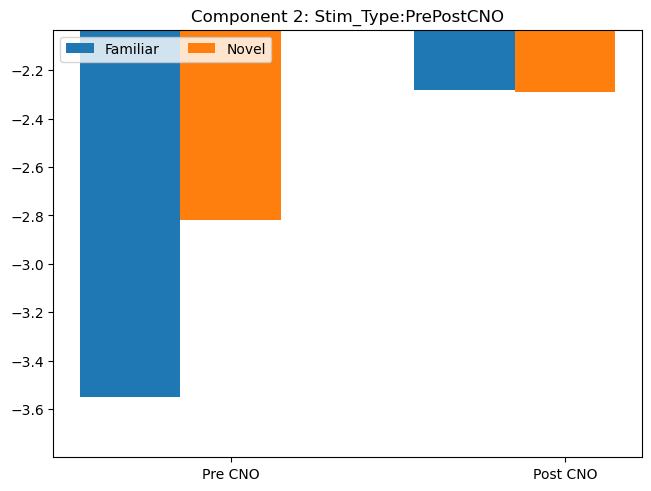

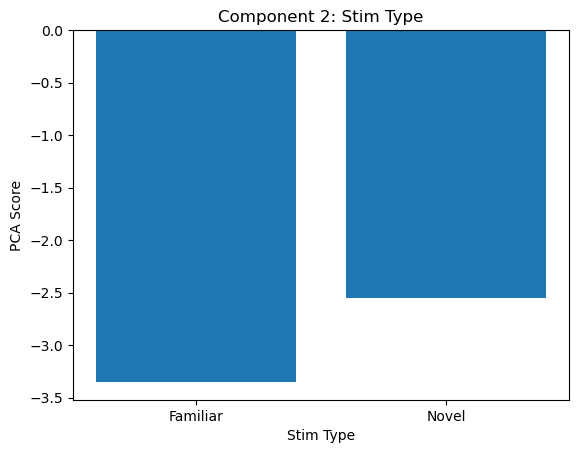

In [213]:
# Relevant Plots for Component 2
Component = 1
display(Anova_Sig.loc[Anova_Sig['Component']==Component+1])
plt.plot(-pca_WT.components_[Component,:])
plt.show()

# Comparing Block and Stim Type:
Stim_DF = np.zeros([2,10,5])
Day1 = PV_Vars[0] == 6 
Day2 = PV_Vars[0] == 7
for k in range(0,2,1):
    
    Fam = PV_Vars[2] == k
    j = 0
    for i in range(0,10,1):
        Block = PV_Vars[4] == i
        
        Comb_Ind =  Block.astype(int) + Fam.astype(int) + Day1.astype(int) + Day2.astype(int)
        Comb_Ind = Comb_Ind == 3
    
        Days = DF_reduced_PV[Comb_Ind,0:5] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1


species = ("Block 1", "Block 2","Block 3","Block 4","Block 5","Block 6","Block 7","Block 8","Block 9","Block 10")
penguin_means = {
    'Familiar': (Stim_DF[0,0,Component],Stim_DF[0,1,Component],Stim_DF[0,2,Component],Stim_DF[0,3,Component],Stim_DF[0,4,Component],\
              Stim_DF[0,5,Component],Stim_DF[0,6,Component],Stim_DF[0,7,Component],Stim_DF[0,8,Component],Stim_DF[0,9,Component]),
    'Novel': (Stim_DF[1,0,Component],Stim_DF[1,1,Component],Stim_DF[1,2,Component],Stim_DF[1,3,Component],Stim_DF[1,4,Component],\
              Stim_DF[1,5,Component],Stim_DF[1,6,Component],Stim_DF[1,7,Component],Stim_DF[1,8,Component],Stim_DF[1,9,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title(f'Component {Component+1}: Block:Stim_Type')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.25,max+.25)

plt.show()

# Comparing Stim Type and PV Inhibition:

Stim_DF = np.zeros([2,2,5])

for k in range(0,2,1):
    
    Fam = PV_Vars[2] == k
    j = 0
    for i in range(0,2,1):
        Block = PV_Vars[0] == i+6
        
        Comb_Ind =  Block.astype(int) + Fam.astype(int)
        Comb_Ind = Comb_Ind == 2
    
        Days = DF_reduced_PV[Comb_Ind,0:5] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1


species = ("Pre CNO","Post CNO")
penguin_means = {
    'Familiar': (Stim_DF[0,0,Component],Stim_DF[0,1,Component]),
    'Novel': (Stim_DF[1,0,Component],Stim_DF[1,1,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title(f'Component {Component+1}: Stim_Type:PrePostCNO')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.25,max+.25)

plt.show()


# Looking at Stim Type for Component 1

Block_DF = np.zeros([2,70])

for i in range(0,2,1):
    Block = PV_Vars[2] == i

    Days = DF_reduced_PV[Block] 
    Block_DF[i] = np.mean(Days,axis = 0)

plt.bar(['Familiar','Novel'],Block_DF[:,Component]) 
plt.xlabel('Stim Type')
plt.ylabel('PCA Score')
plt.title(f'Component {Component+1}: Stim Type')

plt.show()

,Measure,F Value,Num DF,Den DF,Pr > F,Component
8,Stim_Type,9.830768,1.0,8.0,0.013901,3
9,Block:PrePost,3.311732,9.0,72.0,0.001965,3
10,Stim_Type:PrePost,16.412675,1.0,8.0,0.003678,3


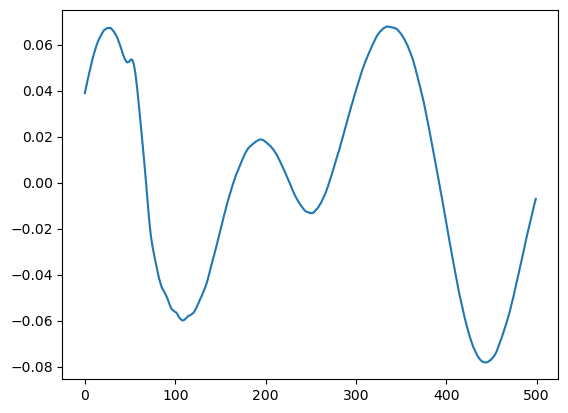

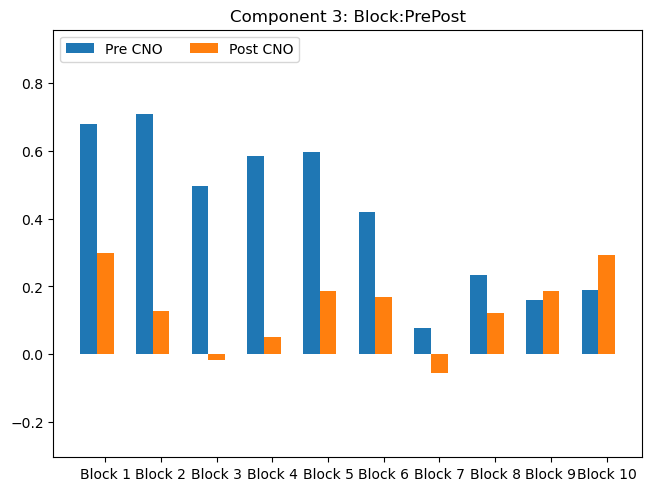

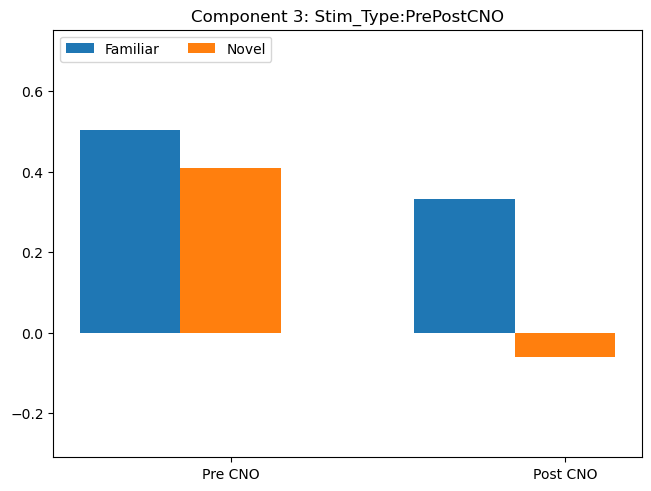

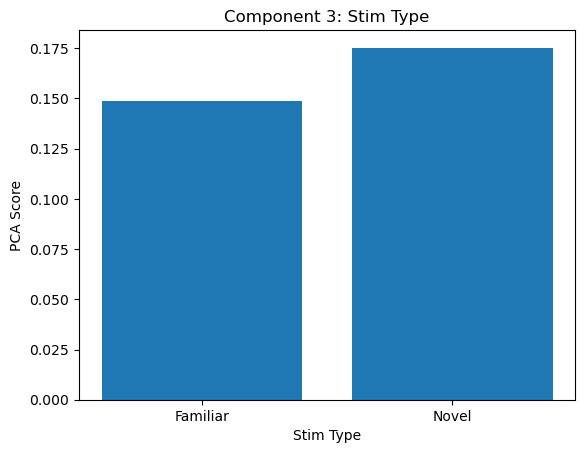

In [221]:
# Relevant Plots for Component 3
Component = 2
display(Anova_Sig.loc[Anova_Sig['Component']==Component+1])
plt.plot(pca_WT.components_[Component,:])
plt.show()

# Comparing Block and Stim Type:
Stim_DF = np.zeros([2,10,5])

for k in range(0,2,1):
    
    Fam = PV_Vars[0] == k+6
    j = 0
    for i in range(0,10,1):
        Block = PV_Vars[4] == i
        
        Comb_Ind =  Block.astype(int) + Fam.astype(int) #+ Day1.astype(int) + Day2.astype(int)
        Comb_Ind = Comb_Ind == 2
    
        Days = DF_reduced_PV[Comb_Ind,0:5] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1


species = ("Block 1", "Block 2","Block 3","Block 4","Block 5","Block 6","Block 7","Block 8","Block 9","Block 10")
penguin_means = {
    'Pre CNO': (Stim_DF[0,0,Component],Stim_DF[0,1,Component],Stim_DF[0,2,Component],Stim_DF[0,3,Component],Stim_DF[0,4,Component],\
              Stim_DF[0,5,Component],Stim_DF[0,6,Component],Stim_DF[0,7,Component],Stim_DF[0,8,Component],Stim_DF[0,9,Component]),
    'Post CNO': (Stim_DF[1,0,Component],Stim_DF[1,1,Component],Stim_DF[1,2,Component],Stim_DF[1,3,Component],Stim_DF[1,4,Component],\
              Stim_DF[1,5,Component],Stim_DF[1,6,Component],Stim_DF[1,7,Component],Stim_DF[1,8,Component],Stim_DF[1,9,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title(f'Component {Component+1}: Block:PrePost')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.25,max+.25)

plt.show()

# Comparing Stim Type and PV Inhibition:

Stim_DF = np.zeros([2,2,5])

for k in range(0,2,1):
    
    Fam = PV_Vars[2] == k
    j = 0
    for i in range(0,2,1):
        Block = PV_Vars[0] == i+6
        
        Comb_Ind =  Block.astype(int) + Fam.astype(int)
        Comb_Ind = Comb_Ind == 2
    
        Days = DF_reduced_PV[Comb_Ind,0:5] 
        Stim_DF[k,j] = np.mean(Days,axis = 0)
        j = j+1


species = ("Pre CNO","Post CNO")
penguin_means = {
    'Familiar': (Stim_DF[0,0,Component],Stim_DF[0,1,Component]),
    'Novel': (Stim_DF[1,0,Component],Stim_DF[1,1,Component])
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title(f'Component {Component+1}: Stim_Type:PrePostCNO')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
min = Stim_DF[:,:,Component].min()
max = Stim_DF[:,:,Component].max()
ax.set_ylim(min-.25,max+.25)

plt.show()


# Looking at Stim Type for Component 1

Block_DF = np.zeros([2,70])

for i in range(0,2,1):
    Block = PV_Vars[2] == i

    Days = DF_reduced_PV[Block] 
    Block_DF[i] = np.mean(Days,axis = 0)

plt.bar(['Familiar','Novel'],Block_DF[:,Component]) 
plt.xlabel('Stim Type')
plt.ylabel('PCA Score')
plt.title(f'Component {Component+1}: Stim Type')

plt.show()